# Data Science en pratique

Arthur Llau: arthur@flowlity.com

# Cours 6 : Algorithmes et techniques avancées

### Objectif du cours:
-  Présentation de quelques algorithmes et implémentations avancées.
-  Présenter rapidemment l'importance des variables
-  TP de mise en pratique (as usual)

## 1 - Algorithmes et implémentations avancées

In [1]:
#Sans wrapper cela ressemble à cela.
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_regression

train, target = make_regression(n_features=10,n_samples=10000)
x_train, x_test, y_train, y_test = train_test_split(train, target, test_size=0.2)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2)


### 1.1 - TabNet 

Original paper (Arik et al., 2020) : https://arxiv.org/pdf/1908.07442.pdf

TabNet est un modèle d'apprentissage automatique pour les données tabulaires, intégrant le principe d'attention (comme dans les transformers !) attention pour se concentrer sur des caractéristiques clés du dataset.

Il combine des aspects des arbres de décision et des réseaux de neurones, offrant à la fois interprétabilité et capacité à capturer des relations complexes.



![](TabNet.png)

In [2]:
from pytorch_tabnet.tab_model import  TabNetRegressor

model = TabNetRegressor(verbose=0,seed=42)
model.fit(X_train=x_train, y_train=y_train.reshape(-1,1),
              eval_set=[(x_valid, y_valid.reshape(-1,1))],
              patience=50, max_epochs=200,
              eval_metric=['rmse'])

#Prediction
preds = model.predict(x_test)
print ('TabNet scoring : {}'.format(mean_squared_error(y_test,preds, squared=False)))

Stop training because you reached max_epochs = 200 with best_epoch = 180 and best_val_0_rmse = 5.74455
TabNet scoring : 5.778974143972639


/home/arthur/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


### 1.2  Boosting & XtremBoosting

Les trois algorithmes décrits ci-dessous sont des méthodes de gradient boosting. LightGBM et Xgboost sont des implémentations dites d'extrême boosting, c'est-à-dire qu'elles sont construites de manière à utiliser du mieu possible les ressources computationnelles et d'un point de vu théorique la différentielle est d'ordre 2.

Il est important de noté que ces méthodes sont implémentés de manière propre mais possède également un wrapper scikit-learn. 


Un autre atout majeur de ces implémentations est l'utilisation de jeux de validation pour obtenir le nombre d'itérations optimal. A chaque itération on regarde si les performances sur le jeu de validation sont améliorés, sinon on arrête. On prend alors la dernière itération la plus performante. Evidemment, il est possible de choisir un nombre d'itération pour lequel il n'y a d'améliorations. (voir Tp)

#### 1.2.1 XGBoost

Original paper (T.Chen, 2016) : https://arxiv.org/abs/1603.02754

Il existe plusieurs diffèrences notable avec l'implémentation du GBT classique : 
-  Ne tiens pas compte des valeurs manquantes...
- Le modèle est mieux régularisé, on contrôle mieux l'overfitting, ce qui explique ces bonnes performances
- On trouve des paramètres de pénalisation $L^1$ et $L^2$, qui n'existe pas dans la version original
- D'autres methodes que les arbres CART peuvent être utilisés: des régréssions linéaire (Linear Boosting), ou des arbres DART (Dropouts meet Multiple Additive Regression Trees, http://proceedings.mlr.press/v38/korlakaivinayak15.pdf)
- On peut résoudre la grande majorité des problématique industrielles  avec  cette implémentation, de la régréssion au ranking, en passant par de la classification multi-classe.
-  Très customisable

On retrouve les même paramètres que pour l'implémentation du GBT dans sklearn. Attention, le nom n'est pas forcément le même, je vous invite à lire la doc.
Cependant, il en existe quelques autres qui sont importants:
- **booster** : type de méthode à booster 
- **objective** : l'objectif du modèle (régéssion, etc.)
- **tree_method** : méthodes de construction des arbres (exact, approx, histogramme)
- **eval_metric** : choix de la métrique d'évaluation

Pour utiliser la version sklearn : "from xgboost import XGBRegressor" (ou XGBClassifier).

/!\ Tous les paramètres ne sont pas disponibles dans le wrapper sklearn.

In [3]:
##### Sans wrapper cela ressemble à cela.
import xgboost as xgb

#Definition des objets d'apprentissage et test
dtrain = xgb.DMatrix(x_train, y_train)
dvalid = xgb.DMatrix(x_valid, y_valid)
dtest = xgb.DMatrix(x_test, y_test)

#Apprentissage
param = {'boost':'linear',
         'learnin_rate':0.1,
         'max_depth': 5, 
         'objective': 'reg:linear',
          'eval_metric':'rmse'}
num_round = 500
bst = xgb.train(param, dtrain,  num_boost_round = num_round, evals=[(dvalid, 'validation')], verbose_eval=100)


#Prediction
preds = bst.predict(dtest)
print ('Xgboost scoring : {}'.format(mean_squared_error(y_test,preds, squared=False)))

[13:53:24] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[13:53:24] WARNING: ../src/learner.cc:767: 
Parameters: { "boost", "learnin_rate" } are not used.

[0]	validation-rmse:130.87800
[100]	validation-rmse:25.75214
[200]	validation-rmse:24.83869
[300]	validation-rmse:24.55199
[400]	validation-rmse:24.51745
[499]	validation-rmse:24.46636
Xgboost scoring : 24.579429350802048


#### 1.2.2 Lightgbm

Original paper (Microsoft Research, 2017) : https://papers.nips.cc/paper/6907-lightgbm-a-highly-efficient-gradient-boosting-decision-tree

De même on trouve des différences majeurs avec les anciennes implémentations:
-   Construction des arbres verticales et non horizontale, i.e, l'algorithme choisi la feuille avec la meilleure loss pour grandir.
-  Très efficace et rapide sur les données sparses, et les gros volumes de données.
-  Comme pour xgboost, d'autres booster sont disponible comme les random forest.
-  Il consomme très peu de ressources mémoire.
-  Résolution de n'importe quel type de problématique.
-  Très customisable

On retrouve les même paramètres que pour l'implémentation du GBT dans sklearn. Attention, le nom n'est pas forcément le même, je vous invite à lire la doc.
Cependant, il en existe quelques autres qui sont importants - les noms varient par rapport à xgb:
- **boosting_type** : type de méthode à booster 
- **task** : l'objectif du modèle (régéssion, etc.)
- **device** : CPU/GPU
- **metric** : choix de la métrique d'évaluation

Pour utiliser la version sklearn : "from lightgbm import LGBMRegressor" (ou LGBMClassifier).

/!\ Tous les paramètres ne sont pas disponibles dans le wrapper sklearn.

In [4]:
import lightgbm as lgb

lgb_train = lgb.Dataset(x_train, y_train)
lgb_valid = lgb.Dataset(x_valid, y_valid)
lgb_test = lgb.Dataset(x_test, y_test, reference=lgb_train)

params = {
   
    'objective': 'regression',
    'metric': {'l2', 'rmse'},

}

print('Start training...')
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=500,
                valid_sets=lgb_valid,
                verbose_eval=100,
                early_stopping_rounds=20) # Arret si 5 iterations sans gain de performance


print('Start predicting...')
preds = gbm.predict(x_test, num_iteration=gbm.best_iteration)
print('LGBM scoring :', mean_squared_error(y_test, preds, squared=False))

Start training...
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000160 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 6400, number of used features: 10
[LightGBM] [Info] Start training from score -2.616338
Training until validation scores don't improve for 20 rounds
[100]	valid_0's l2: 421.072	valid_0's rmse: 20.52
[200]	valid_0's l2: 337.443	valid_0's rmse: 18.3696
[300]	valid_0's l2: 315.983	valid_0's rmse: 17.7759
[400]	valid_0's l2: 306.518	valid_0's rmse: 17.5077


/home/arthur/anaconda3/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/arthur/anaconda3/lib/python3.11/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[500]	valid_0's l2: 301.825	valid_0's rmse: 17.3731
Did not meet early stopping. Best iteration is:
[500]	valid_0's l2: 301.825	valid_0's rmse: 17.3731
Start predicting...
LGBM scoring : 17.713142807560025


#### 1.2.3 CatBoost

Original paper (Yandex, 2017) : https://arxiv.org/abs/1706.09516

Dernier né de la firme russe Yandex, CatBoost est une implémentation similaire à celle de xgboost et de lightgbm mais qui a la particularité de tenir compte des variables catégorielles pour l'apprentissage. L'algorithme va construire à partir des variables catégorielles diverses statistiques* et, tenir compte de celles-ci pour l'apprentissage. On trouve quelque différences notables avec les deux autres algorithmes présentés ci-dessous:
- Très performant mais très lent.
- Pas d'autre booster que les arbres de disponibles
- Deux taches : régréssion ou classification
- Plusieurs paramètres pour l'apprentissage des variables catégorielles.
- Paramètres de détéction de l'overfitting
- Il y a une interface graphique super sexy...

*Voir https://tech.yandex.com/catboost/doc/dg/concepts/algorithm-main-stages_cat-to-numberic-docpage/

Quelques paramètres importants :
- **iterations** : nombre d'arbres
- **eval_metric** : la métrique d'évaluation
- **ctr** : paramètre de transformation des variables catégorielles
- **fold_permutation_block_size** : nombre de permutations des catégorielles

Pour utiliser la version sklearn : "from catboost import CatBoostRegressor" (ou CatBoostClassifier).
Et pour utiliser l'apprentissage sur les variables catégorielles, ajouter dans *fit* cat_features = [index des features catégorielles].

/!\ Tous les paramètres ne sont pas disponibles dans le wrapper sklearn.

In [5]:
import catboost as cat

train_pool = cat.Pool(x_train, y_train)
valid_pool = cat.Pool(x_valid, y_valid)
test_pool = cat.Pool(x_test)

param = {'logging_level':'Silent'}
model = cat.CatBoost(param)
model.fit(train_pool,eval_set=valid_pool) 

preds = model.predict(test_pool)
print('Cat scoring :', mean_squared_error(y_test, preds, squared=False))

Cat scoring : 7.778429388956582


Notez que les trois implémentations ci-dessus sont également portable sur GPU.

Chaque algorithme aura des performances différentes selon le jeu de données et le problème à traiter, à vous de choisir (et de tester) le meilleur modèle.

### 1.3 - Regularized Greedy Forest

Original paper (R. Johnson et al., 2014) : https://arxiv.org/pdf/1109.0887.pdf

Popularisé il y a peu les RGF sont une sorte de mélange entre des forêts aléatoire et du boosting. Résumé de manière naïve, c'est une fôret aléatoire où chaque arbre est régularisé, et l'ensemble de la fôret également.

C'est un algorithme puissant mais complexe, je vous invite si cela vous intéresse à lire le papier original.

La liste des paramètres est disponible ici : https://github.com/fukatani/rgf_python

Deux modèles sont implémentés : RGFRegressor et RGFClassifier du package rgf_python.

### 1.4 Autres algorithmes plus ou moins célèbres

Vous pouvez également vous penchez sur les algorithmes suivant : 
- Rotation Forest : http://ieeexplore.ieee.org/document/1677518/ PCA sur des K-Folds pour chaque arbre de la forêt
- Adaptative Hybrid Extreme Rotation Forest (AdaHERF) : https://www.ncbi.nlm.nih.gov/pubmed/24480062 Rotation Forest + Extreme Learning
- FTRL (Follow-the-Regularized-Leader) : https://static.googleusercontent.com/media/research.google.com/fr//pubs/archive/37013.pdf


**Aparté sur les Neural Net**

En pratique sur certains jeux de données ils sont équivalent en terme de performance aux meilleurs méthodes de boosting. 

Cependant plusieurs contraintes :
- la recherche d'architecture
- la calibration 
- la reproductibilité
- la mise en production

## Et le non supervisé ?

Il existe également d'autres algorithme que ceux vu en cours pour la réduction de dimension et le clustering :
- T-SNE & variantes (Réduction de dimensions, https://lvdmaaten.github.io/tsne/) : Minimiser la divergence de KL
- TruncatedSVD (Réduction de dimensions, voir cours de C.Boyer)
- SparsePCA (Réduction de dimensions, https://arxiv.org/abs/1211.1309) : PCA sur des données sparses
- HDDBScan (Clustering, https://link.springer.com/chapter/10.1007%2F978-3-642-37456-2_14) : Clustering par densité
- AutoEncoder for Clustering (https://arxiv.org/abs/2102.07472)

Pour découvrir de nouveaux algorithmes je vous invite à consulter les divers forums de machine learning indiqué au premier cours, ainsi que les papiers des conférences NIPS, ICML & MLConf...

## 2 - Feature importance & Feature Selection

### 2.1 - Feature importance

#### 2.1.0 Définition

On parle de feature importance presque uniquement dans le cas des algorithmes de machine learning basé sur les arbres CART.
L'importance d'une variable, n'est autre que le poids - selon une mesure donnée - qu'apporte cette variable dans l'apprentissage. 
Pour les arbres CART on retrouve la définition suivante :


*Les arbres aléatoires sont une règle de décision interprétable pour la prédiction des classes.En effet, les variables de découpe sont choisies selon leur capacité à classifier les données. De ce fait, une variable permettant de découper les premiers nœuds a un pouvoir discriminant plus important qu’une variable apparaissant dans les dernières découpes (ou n’apparaissant pas dans l’arbre). * B.Gregorutti- https://tel.archives-ouvertes.fr/tel-01146830/document

Dans les méthodes d'ensemble, l'importance des features est calculé généralement de la manière suivante:
On compte le nombre de fois où la variable est séléctionné pour séparer un noeud, pondéré par l'amélioration du modèle à chaque séparation. Puis on moyenne les résultats.

Pour résumer : variable très utilisée qui sépare bien les données = variable importante.

#### 2.1.1 Permutation importance

La permutation importance est une autre méthode pour calculer l'importance des features, elle a les particularités suivantes:
- Calcul rapide
- Beaucoup utilisée et comprise
- Consistante


__Comment ça marche ?__

- 0. Découper en train test
- 1. Faire apprendre un modèle sur nos données
- 2. Mesurer les performances du modèle
- 3. Mélanger les valeurs d'une colonne d'un jeu de test puis prédire
- 4. Evaluer de nouveau les performances

Plus la métrique souffre de ce changement plus la variable est importante.

-> Remettre en place la colonne, puis répéter sur toutes les variables du jeu de données

#### 2.1.2 LOFO

LOFO (Leave One Feature Out) Importance calcule l'importance pour un ensemble de variable, basé sur une métrique choisi, avec un modèle choisi. Itérativement une variable va être enlevé de l'ensemble puis on va réévaluer les performances du modèles avec un schéma de validation choisi.

https://github.com/aerdem4/lofo-importance

Avantages :

- Se généralise bien aux données non observées
- Indépendant du modèle
- Donne une importance négative aux variables qui dégrade les performances en les incluants.


### 2.2 - Feature Selection

Il est parfois nécéssaire d'effectuer une séléction des variables utilisées dans le modèle pour plusieurs raisons:
- Trop de corrélations entre certaines variables
- Trop de variables ce qui entraine un temps de calcul excessif
- Expertise métier
- Problème de dimension
- Variable à la distribution étrange
- Et enfin, importance faible

Il existe alors plusieurs technique pour séléctionner les variables, autre que les critères d'Akkaike etc.


Voici la liste de ceux que j'utilise en pratique:

- VarianceThreshold : On supprime les features avec une variance dépassant un certain seuil.
- SelectKBest : On ne séléctionne que les $k$ features les plus important
- RFECV : On supprime récursivement des features et on regarde les performance du modèle

Tous ces modèles de séléction sont disponible dans sklearn.


## TP de mise en pratique


Les données proviennent du Kaggle suivant : https://www.kaggle.com/c/house-prices-advanced-regression-techniques

La variable à prédire est la "SalePrice".


In [6]:
import pickle
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns,time

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor


warnings.filterwarnings('ignore')

**1.1** Le fichier datasets.pkl contient différents dataframe, ouvre le fichier puis observer les clés.

In [7]:
datasets = pd.read_pickle('tp-data/datasets.pkl')

In [8]:
datasets.keys() # 3 dataframe et les deux targets

dict_keys(['y_train', 'y_test', 'only_categorical', 'only_nan', 'full_clean'])

**2.1** Extrayez les targets

In [9]:
# Récupérer les targets
y_train = datasets['y_train']
y_test = datasets['y_test']

**2.2** Extrayez le train et le test restant pour le jeu de données "full_clean"


In [12]:
train_full = datasets['full_clean']['train']
test_full = datasets['full_clean']['test']

**3** Quelle mesure de performance devrions nous utiliser ? Implémentez la.

La rmse semble pertinente, implémentons-la !

In [14]:
def rmse(preds, targets):
    return np.sqrt(((preds - targets) ** 2).mean())

**4** Comparez xgboost, lightgbm, catboost, extratrees, et une régression au choix sur le jeu de données full adéquat à chaque algorithme, sans chercher à optimiser les paramètres des modèles. Donnez également le temps de calcul nécessaire à l'apprentissage. 
Faites une fonction !

In [15]:
regressors_list = []
regressors_list.append({'reg':XGBRegressor(),'name':'XGBRegressor'})
regressors_list.append({'reg':LGBMRegressor(),'name':'LGBMRegressor'})
regressors_list.append({'reg':CatBoostRegressor(logging_level='Silent'),'name':'CatBoostRegressor'})
regressors_list.append({'reg':ExtraTreesRegressor(),'name':'ExtraTreesRegressor'})
regressors_list.append({'reg':LinearRegression(),'name':'LinearRegression'})

def training_and_evaluation(regressor_list, x_train, y_train, x_test, y_test):
        for regressor in regressor_list:
            model = regressor['reg']
            t0 = time.time()
            try:
                model.fit(x_train, y_train)
            except ValueError as err:
                print(f'{err}')
            t1 = time.time()
            preds = model.predict(x_test)
            print(f"{regressor['name']} apprend en {t1-t0:.3f}s et a une performance de {rmse(y_test, preds):.2f}")
    

In [16]:
training_and_evaluation(regressors_list,train_full,y_train,test_full,y_test)


XGBRegressor apprend en 0.153s et a une performance de 26715.51
LGBMRegressor apprend en 0.075s et a une performance de 27184.29
CatBoostRegressor apprend en 0.804s et a une performance de 24594.74
ExtraTreesRegressor apprend en 0.923s et a une performance de 28630.18
LinearRegression apprend en 0.007s et a une performance de 33652.61


**6.1** Choisissez deux de vos modèles, faites leur apprendre à nouveau le jeu de données et affichez l'importance des 20 features les plus importants, qu'observez vous ?

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

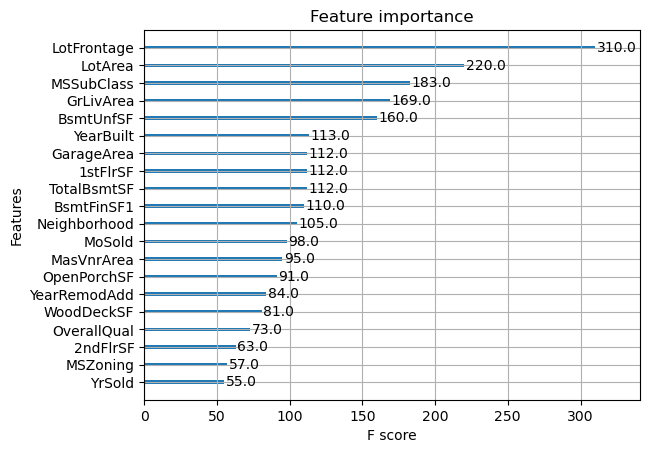

In [17]:
from xgboost import plot_importance
model = XGBRegressor()
model.fit(train_full, y_train)
plot_importance(model, max_num_features=20)

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

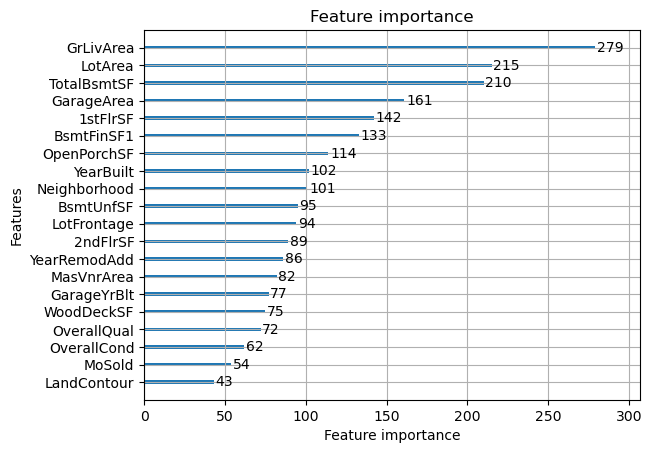

In [18]:
from lightgbm import plot_importance
model = LGBMRegressor()
model.fit(train_full, y_train)
plot_importance(model, max_num_features=20)

**6.2** Utiliser lofo pour afficher l'importance des features grâce  à la methode leave one out.

  0%|          | 0/79 [00:00<?, ?it/s]

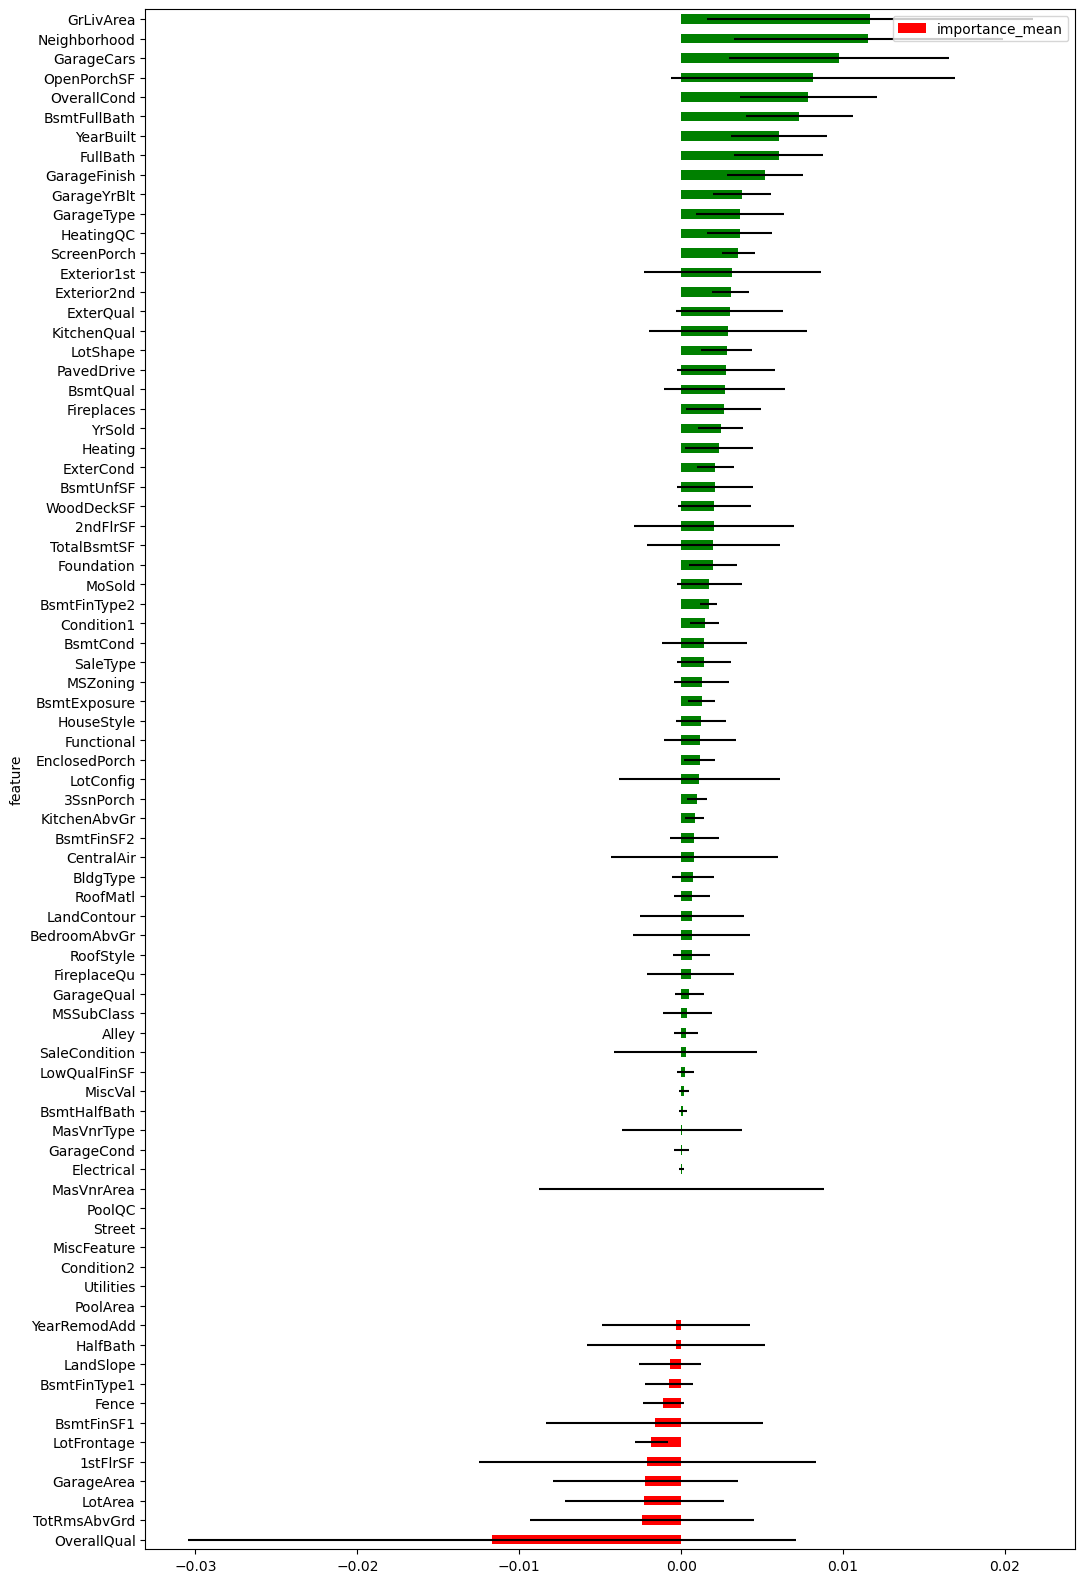

In [19]:
from lofo import LOFOImportance, Dataset, plot_importance
from sklearn.model_selection import KFold

cv = KFold(n_splits=4, shuffle=False, random_state=None) 

dataset = Dataset(df=pd.concat([train_full, y_train], axis=1), target="SalePrice", features=[col for col in train_full.columns if col != "HasDetections"])

lofo_imp = LOFOImportance(dataset, cv=cv, scoring="r2")
importances = lofo_imp.get_importance()
plot_importance(importances, figsize=(12, 20))


**7** Entrainez à nouveau les modèles mais seulement sur les 20 features les plus importants d'un des deux modèles. Donnez également le temps de calcul nécessaire à l'apprentissage et les performances sur le jeu de test. Qu'observez-vous ?

In [20]:
importances.head() # déjà ordonné

,feature,importance_mean,importance_std,val_imp_0,val_imp_1,val_imp_2,val_imp_3
64,GrLivArea,0.011654,0.010085,0.023173,-0.004369,0.011998,0.015814
58,Neighborhood,0.011563,0.008287,0.020580,0.010307,-0.001309,0.016672
18,GarageCars,0.009736,0.006792,0.019968,0.008963,0.009157,0.000855
21,OpenPorchSF,0.008151,0.008771,0.012755,0.005465,-0.004588,0.018970
52,OverallCond,0.007865,0.004255,0.009456,0.001364,0.007529,0.013109


In [21]:
#Recuper les 20 features les plus important de catboost
best_features = importances.feature.tolist()[:20]
train_importance = train_full[best_features]
test_importance = test_full[best_features]

In [22]:
training(regressors_list, train_importance,y_train,test_importance,y_test)

XGBRegressor apprend en 0.099s et a une performance de 29600.83
LGBMRegressor apprend en 0.036s et a une performance de 32294.25
CatBoostRegressor apprend en 0.454s et a une performance de 30002.96
ExtraTreesRegressor apprend en 0.282s et a une performance de 31835.87
LinearRegression apprend en 0.002s et a une performance de 37001.29


Ne prendre qu'un certain nombre des features importante dégrade les performances de nos modèles, mais cependant le temps de calcul est grandement amélioré. Il faut donc trouver un compromis entre performance et temps de calcul, selon le problème donné.

**8** Jouez avec les paramètres des modèles, et déterminer le plus performant sur le jeu de test.

In [23]:
regressors_list = []
regressors_list.append({'reg':XGBRegressor(max_depth=2),'name':'XGBRegressor'})
regressors_list.append({'reg':LGBMRegressor(num_leaves=12),'name':'LGBMRegressor'})
regressors_list.append({'reg':CatBoostRegressor(logging_level='Silent'),'name':'CatBoostRegressor'})
regressors_list.append({'reg':ExtraTreesRegressor(n_estimators=200),'name':'ExtraTreesRegressor'})
regressors_list.append({'reg':LinearRegression(),'name':'LinearRegression'})

training_and_evaluation(regressors_list,train_full,y_train,test_full,y_test)


XGBRegressor apprend en 0.616s et a une performance de 29989.86
LGBMRegressor apprend en 0.051s et a une performance de 26401.34
CatBoostRegressor apprend en 0.797s et a une performance de 24594.74
ExtraTreesRegressor apprend en 1.637s et a une performance de 28755.92
LinearRegression apprend en 0.003s et a une performance de 33652.61


**9** Utilisez un ensemble de validation pour connaitre le nombre d'itérations optimal de boosting avec Xgboost puis avec catboost avec ou sans wrapper sklearn.

In [24]:
from sklearn.model_selection import train_test_split
X_tr,X_va,Y_tr,Y_va = train_test_split(train_full,y_train)

model = XGBRegressor(n_estimators=1000)
model.fit(X_tr,Y_tr,eval_set=[(X_va,Y_va)],early_stopping_rounds=50,verbose=20)
print( rmse(y_test,model.predict(test_full)))

[0]	validation_0-rmse:143065.79707
[20]	validation_0-rmse:28093.91662
[40]	validation_0-rmse:28088.11814
[60]	validation_0-rmse:27968.61678
[80]	validation_0-rmse:28006.18724
[100]	validation_0-rmse:28021.27878
[110]	validation_0-rmse:28029.69030
26037.579819205148


In [25]:

model = CatBoostRegressor(n_estimators=1000)

model.fit(X_tr,Y_tr,eval_set=[(X_va,Y_va)],cat_features=cat_features_idx,early_stopping_rounds=100,verbose=10)
print (rmse(y_test,model.predict(test_full)))

Learning rate set to 0.049368
0:	learn: 77616.7473181	test: 69263.2951579	best: 69263.2951579 (0)	total: 6.12ms	remaining: 6.12s
10:	learn: 59291.3065341	test: 51793.7768966	best: 51793.7768966 (10)	total: 57.1ms	remaining: 5.13s
20:	learn: 47076.9029155	test: 40653.0584581	best: 40653.0584581 (20)	total: 105ms	remaining: 4.9s
30:	learn: 40206.7334679	test: 34667.4158795	best: 34667.4158795 (30)	total: 149ms	remaining: 4.65s
40:	learn: 34821.0319737	test: 30576.5192356	best: 30576.5192356 (40)	total: 200ms	remaining: 4.68s
50:	learn: 31311.8265893	test: 28108.5419283	best: 28108.5419283 (50)	total: 249ms	remaining: 4.63s
60:	learn: 28716.2224346	test: 26403.5570896	best: 26403.5570896 (60)	total: 306ms	remaining: 4.71s
70:	learn: 26809.5013733	test: 25307.1843192	best: 25307.1843192 (70)	total: 357ms	remaining: 4.67s
80:	learn: 25536.2100084	test: 24721.0832501	best: 24721.0832501 (80)	total: 406ms	remaining: 4.61s
90:	learn: 24330.7097220	test: 24251.8797508	best: 24251.8797508 (90)	t

820:	learn: 6856.3142252	test: 19896.5931184	best: 19896.5931184 (820)	total: 4.2s	remaining: 916ms
830:	learn: 6791.5587173	test: 19886.5409728	best: 19886.5409728 (830)	total: 4.25s	remaining: 865ms
840:	learn: 6729.5582630	test: 19878.7195455	best: 19878.7195455 (840)	total: 4.3s	remaining: 813ms
850:	learn: 6667.3605743	test: 19877.8020753	best: 19877.1461077 (849)	total: 4.35s	remaining: 762ms
860:	learn: 6583.6773410	test: 19883.3937177	best: 19877.1461077 (849)	total: 4.4s	remaining: 710ms
870:	learn: 6521.5897029	test: 19875.5569326	best: 19873.0242600 (867)	total: 4.45s	remaining: 659ms
880:	learn: 6437.9252978	test: 19870.4520565	best: 19857.7830791 (874)	total: 4.5s	remaining: 608ms
890:	learn: 6379.9917037	test: 19860.3161607	best: 19857.7830791 (874)	total: 4.55s	remaining: 557ms
900:	learn: 6322.0801974	test: 19857.5271091	best: 19851.3647526 (896)	total: 4.61s	remaining: 506ms
910:	learn: 6265.7682986	test: 19841.4667629	best: 19841.4667629 (910)	total: 4.66s	remaining: 

**10** Comment améliorer les résultats ?

- Utiliser des statistiques autour des prix pour construire de nouvelles variables
- Remplir les NA de manière plus intelligente
- Importer des données externes, comment des position géographiques
- Utiliser des méthodes d'agrégation
- Stacker plusieurs modèles